In [2]:
import numpy as np
import pandas as pd

import pylab as plt
import seaborn as sns

from scipy import stats as st
from statsmodels.api import add_constant, OLS

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

from statsmodels.api import add_constant, OLS
from statsmodels.formula.api import ols

import pylab as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


In [3]:
casas=pd.read_csv('D:/UAX/2º Curso/IronHack/Proyecto_Final/regression_data1.csv')
casas.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,7129300520,10/13/2014,3,1.00,1180,5650,1.0,0,0,3,...,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,221900
1,6414100192,12/9/2014,3,2.25,2570,7242,2.0,0,0,3,...,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,538000
2,5631500400,2/25/2015,2,1.00,770,10000,1.0,0,0,3,...,770,0,1933,0,98028,47.7379,-122.233,2720,8062,180000
3,2487200875,12/9/2014,4,3.00,1960,5000,1.0,0,0,5,...,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,604000
4,1954400510,2/18/2015,3,2.00,1680,8080,1.0,0,0,3,...,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,510000


In [4]:
cte_cols = []

for c in casas.select_dtypes(include=np.number): # para columnas de tipo numérico
    
    if casas[c].std()==0:
        cte_cols.append(c)
        
cte_cols
# no hay datos duplicados

[]

In [5]:
casas.info()
#no hay datos nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   bedrooms       21597 non-null  int64  
 3   bathrooms      21597 non-null  float64
 4   sqft_living    21597 non-null  int64  
 5   sqft_lot       21597 non-null  int64  
 6   floors         21597 non-null  float64
 7   waterfront     21597 non-null  int64  
 8   view           21597 non-null  int64  
 9   condition      21597 non-null  int64  
 10  grade          21597 non-null  int64  
 11  sqft_above     21597 non-null  int64  
 12  sqft_basement  21597 non-null  int64  
 13  yr_built       21597 non-null  int64  
 14  yr_renovated   21597 non-null  int64  
 15  zipcode        21597 non-null  int64  
 16  lat            21597 non-null  float64
 17  long           21597 non-null  float64
 18  sqft_l

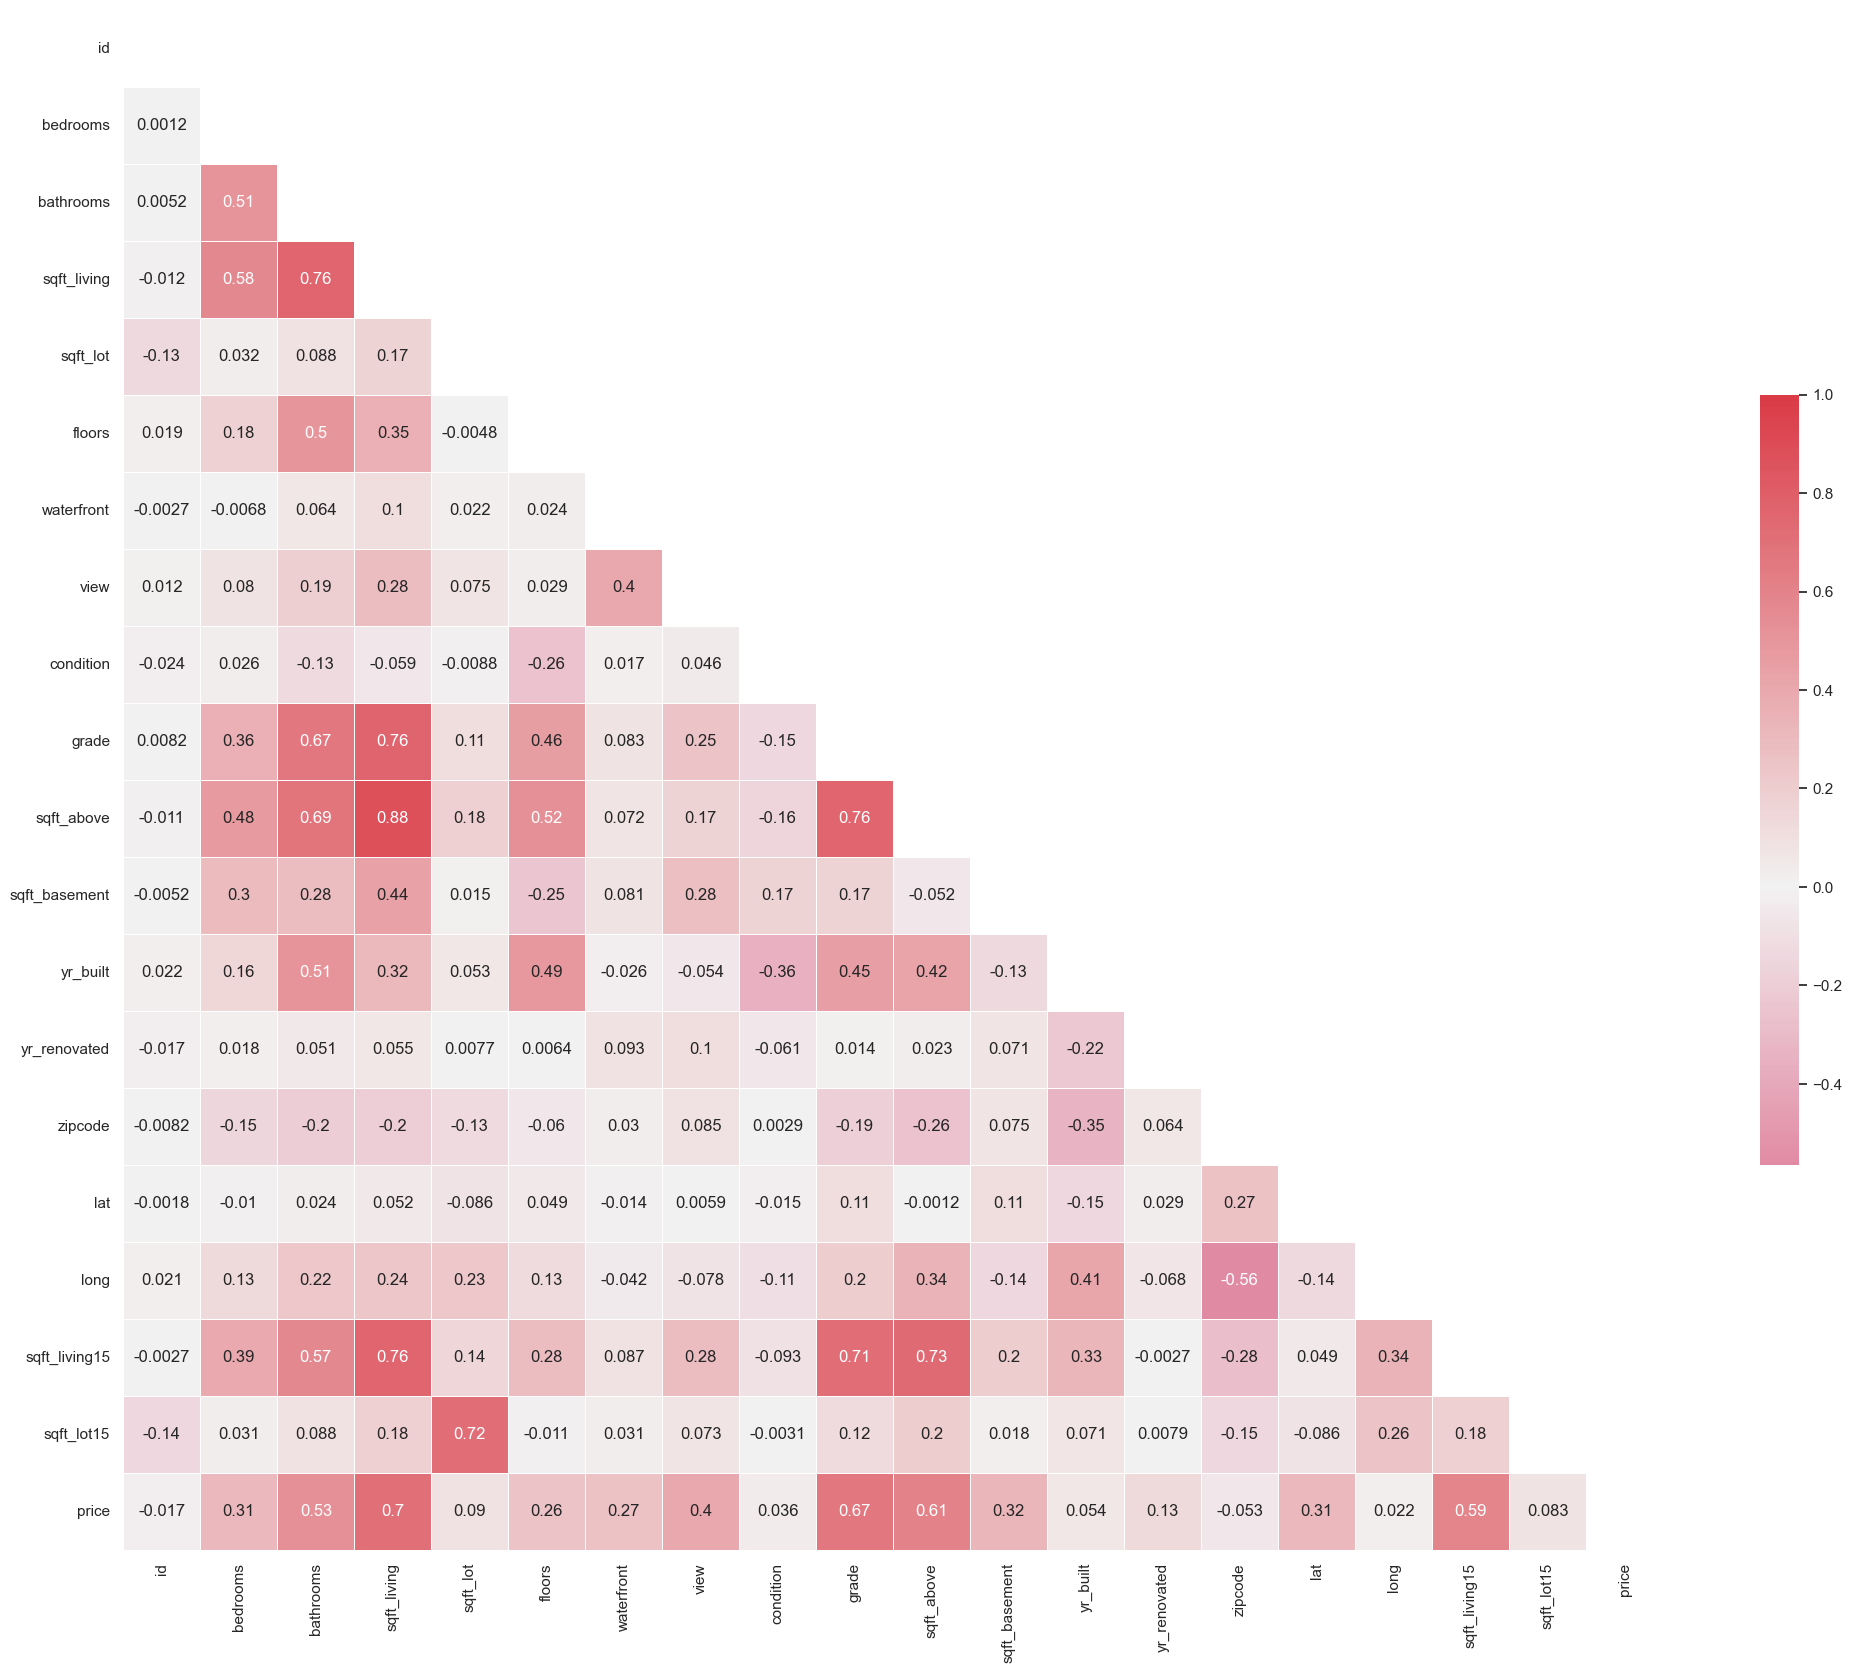

In [6]:
plt.rcParams['figure.figsize']=(25, 20)  # tamaño por defecto para los plots
def print_heatmap_corr(data:pd.DataFrame, annot:bool=True, cmap:str=None, 
                       mask:bool=True, save:bool=False, title:str=None)->None:
    
    '''
        Función que recibe un dataframe y devuelve la matriz de correlación en forma de mapa de color
        
        Parameters:
        -----------
        
        data: Dataset sobre el que queremos realizar la matriz de correlación
        annot: Si queremos mostrar el valor de la correlación en la matriz, default = True
        cmap: Paleta de colores que queremos usar para nuestro heatmap
        mask: Parámetro para mostrar solo la triangular inferior de la matriz de correlación
        save: Parámetro para salvar nuestro gráfico
        title: Título que queremos que lleve nuestro gráfico
    '''
    
    sns.set(style='white')     # estilo blanco hace que el fondo de la matriz sea transparente

    if mask: # Si mask es True
        mascara=np.triu(np.ones_like(data.corr(), dtype=bool))   # genera una mascara para tapar valores
    else:
        mascara = None # No aplicamos máscar

    if cmap: # Si le hemos pasado una paleta de colores
        c_map = sns.color_palette(cmap, as_cmap=True)
    else:
        c_map=sns.diverging_palette(0, 10, as_cmap=True)   # paleta de colores por defecto


    p = sns.heatmap(data.corr(), # aplica el método corr() a nuestro dataset
            mask=mascara, # aplica la mascara
            cmap=c_map, # aplica la paleta de colores
            vmax=1, # para establecer el valor máximo de valores
            center=0, # establece el centro de la paleta de colores
            square=True,
            linewidth=0.5, # para aplicar borde a los cuadros de la matriz
            cbar_kws={'shrink': 0.5}, # mostrar leyenda de colores
            annot=annot # mostrar valores de la matriz
           )
    p.set_title(title, fontsize=20)
    
    if save:
        try:
            plt.savefig(f'graphics/{title}.png')
        except:
            destino = input('No exite la carpeta de destino, introduce un nombre para la carpeta de destino: ')
            os.mkdir(destino)
            plt.savefig(f'{destino}/{title}.png')
    
    plt.show();
    

print_heatmap_corr(casas)

In [7]:
casas.drop("id", axis="columns", inplace=True) #no es relevante porque no aporta informacion acerca del precio
#casas.drop("lat", axis="columns", inplace=True) # no es relevante porque todas las casas estan en la misma zona
casas.drop("long", axis="columns", inplace=True)#no es relevante porque todas las casas estan en la misma zona
casas.drop("zipcode", axis="columns", inplace=True) # no es relevante porque todas las casas estan en la misma zona

In [8]:
# creo una columna que calcula los metros cuadrados totales incluyendo sotano, plantas y terreno sea o no  habitable
casas["sqft_total"]= sum(sum(casas["sqft_lot"] , casas["sqft_above"]) , casas["sqft_basement"])
casas.drop("sqft_lot", axis="columns", inplace=True)
casas.drop("sqft_above", axis="columns", inplace=True)
casas.drop("sqft_basement", axis="columns", inplace=True)

In [9]:
# creo una nueva columna last renovation, que junta las columnas year_built y year_renovated
casas["last_renovation"] = casas[["yr_built","yr_renovated"]].max(axis=1)
casas.drop("yr_built", axis="columns", inplace=True)
#casas.drop("yr_renovated", axis="columns", inplace=True)

In [10]:
#casas.drop("bedrooms", axis="columns", inplace=True) # esta información es no es util sabiendo los metros cuadrados
#casas.drop("bathrooms", axis="columns", inplace=True) # esta informacion no es util sabiendo los metros cuadrados
#casas.drop("condition", axis="columns", inplace=True) #condition no es utill sabiendo el grade
casas.drop("floors", axis="columns", inplace=True) # esta informacion no es util sabiendo los metros cuadrados
#casas.drop("waterfront", axis="columns", inplace=True) #esta informacion no es util pues el precio es equivalente con o sin waterfront
casas.drop("sqft_lot15", axis="columns", inplace=True)

In [11]:
casas.price.describe().T

count    2.159700e+04
mean     5.402966e+05
std      3.673681e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

In [12]:

def remove_outliers_from_dataframe(df, col, threshold: float = 3):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    intraquartile_range = q3 - q1
    fence_low  = q1 - threshold * intraquartile_range
    fence_high = q3 + threshold * intraquartile_range
    return df.loc[(df[col] > fence_low) & (df[col] < fence_high)]


casas=remove_outliers_from_dataframe(casas, "price")




In [13]:
casas.price.describe().T

count    2.117700e+04
mean     5.062684e+05
std      2.579377e+05
min      7.800000e+04
25%      3.200000e+05
50%      4.468000e+05
75%      6.267000e+05
max      1.610000e+06
Name: price, dtype: float64

In [14]:
#casas.drop("last_renovation", axis="columns", inplace=True)
casas.drop("sqft_total", axis="columns", inplace=True)
casas.drop("view", axis="columns", inplace=True)
#casas.drop("sqft_living", axis="columns", inplace=True)

In [15]:
#reordeno las columnas para que price esté al final
precio = casas['price'] 
n= len(casas.columns)
casas.drop(labels=['price'], axis="columns",inplace = True)
casas.insert(n-1, 'price', precio)


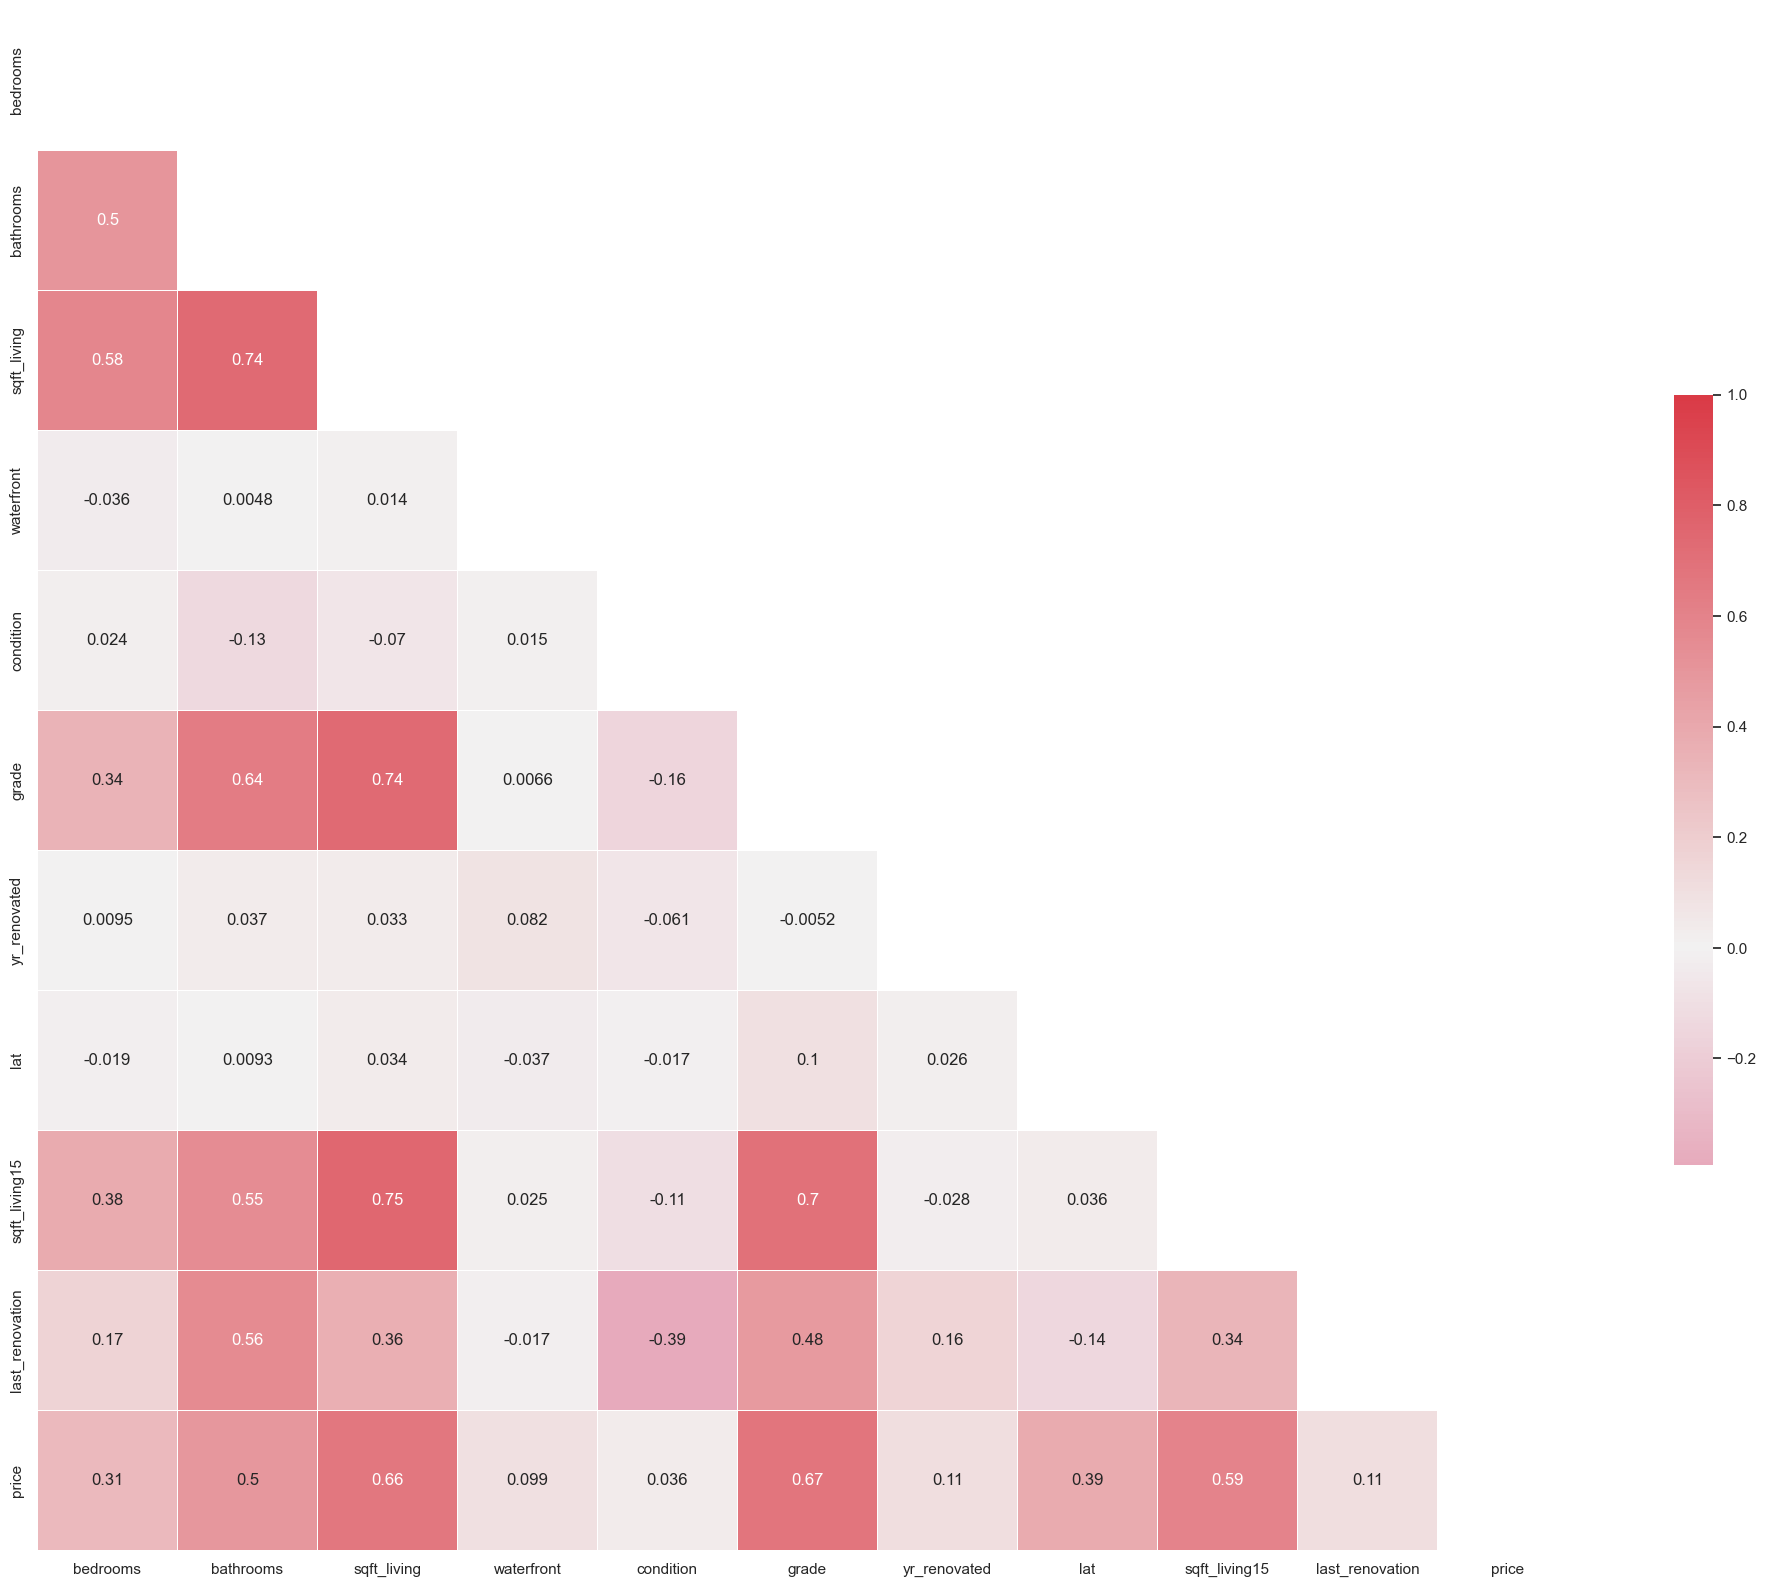

In [16]:
print_heatmap_corr(casas)

In [17]:
casas.corr()

,bedrooms,bathrooms,sqft_living,waterfront,condition,grade,yr_renovated,lat,sqft_living15,last_renovation,price
bedrooms,1.000000,0.503754,0.583142,-0.036488,0.023524,0.339308,0.009463,-0.018503,0.380581,0.167876,0.312045
bathrooms,0.503754,1.000000,0.735238,0.004759,-0.134503,0.639672,0.036918,0.009276,0.548879,0.555755,0.495035
sqft_living,0.583142,0.735238,1.000000,0.013938,-0.070275,0.737371,0.033140,0.034247,0.751458,0.361941,0.664057
waterfront,-0.036488,0.004759,0.013938,1.000000,0.015441,0.006560,0.081841,-0.036740,0.024566,-0.017317,0.099250
condition,0.023524,-0.134503,-0.070275,0.015441,1.000000,-0.160755,-0.061069,-0.016871,-0.107654,-0.392196,0.035758
grade,0.339308,0.639672,0.737371,0.006560,-0.160755,1.000000,-0.005158,0.102318,0.696625,0.478979,0.671612
yr_renovated,0.009463,0.036918,0.033140,0.081841,-0.061069,-0.005158,1.000000,0.025739,-0.027529,0.160720,0.106474
lat,-0.018503,0.009276,0.034247,-0.036740,-0.016871,0.102318,0.025739,1.000000,0.035904,-0.139605,0.385839
sqft_living15,0.380581,0.548879,0.751458,0.024566,-0.107654,0.696625,-0.027529,0.035904,1.000000,0.336204,0.594033
last_renovation,0.167876,0.555755,0.361941,-0.017317,-0.392196,0.478979,0.160720,-0.139605,0.336204,1.000000,0.107909


In [18]:
X= casas.drop(["price","date"], axis="columns") 
y= casas["price"]

In [19]:
def plot_regression_model(x,y):
    
    x_const = add_constant(x) # add a constant to the model
    
    modelo = OLS(y, x_const).fit() # fit the model
    
    pred = modelo.predict(x_const) # make predictions
    
    print(modelo.summary());
    try:
        const = modelo.params[0] # create a variable with the value of the constant given by the summary
        coef = modelo.params[1] # create a variable with the value of the coef given by the summary

        x_l=np.linspace(x.min(), x.max(), 50) 
        y_l= coef*x_l + const # function of the line

        plt.figure(figsize=(10, 10));

        # plot the line
        plt.plot(x_l, y_l, label=f'{x.name} vs {y.name}={coef}*{x.name}+{const}');

        # data
        plt.scatter(x, y, marker='x', c='g', label=f'{x.name} vs {y.name}');

        plt.title('Regresion lineal')
        plt.xlabel(f'{x.name}')
        plt.ylabel(f'{y.name}')
        plt.legend()
        plt.show();
        return modelo
    except:
        print('No se puede imprimir la recta de regresión para modelos multivariable')
        plt.show();
        return modelo



In [20]:
"""
for c in X:
    plot_regression_model(X[c], y)

"""

'\nfor c in X:\n    plot_regression_model(X[c], y)\n\n'

In [21]:
multi = plot_regression_model(X,y)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     4837.
Date:                Fri, 09 Dec 2022   Prob (F-statistic):               0.00
Time:                        20:37:14   Log-Likelihood:            -2.8133e+05
No. Observations:               21177   AIC:                         5.627e+05
Df Residuals:                   21166   BIC:                         5.628e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -2.226e+07    3.8e+05    -

<Figure size 1000x1000 with 0 Axes>

In [22]:
X_train ,X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size=.2)

In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse

In [24]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf.score(X_train, y_train), rf.score(X_test, y_test)

(0.9741159675216685, 0.8170190096625982)

In [25]:
mse(y_train, rf.predict(X_train)), mse(y_test, rf.predict(X_test)) 

(1706262070.904753, 12616167304.008022)

In [26]:
mse(y_train, rf.predict(X_train), squared=False), mse(y_test, rf.predict(X_test), squared=False) 


(41306.92521726536, 112321.7134128928)